In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
from mplsoccer import VerticalPitch
import pandas as pd
import numpy as np
from source_plotting import * 
import xml.etree.ElementTree as et
from mplsoccer import Pitch
import math
import json
from datetime import datetime
import copy
from sys import intern
import pickle
from IPython.display import display
from pathlib import Path
from tqdm import tqdm
from sklearn.cluster import KMeans
from scipy.spatial import distance

Matches Parser Class

In [2]:
class Matches():

    def __init__(self, matches_path = "data/matches.json"):
        self.matches_path = matches_path
        self.matches_df, self.match_ids, self.date_times, self.home_teams, self.away_teams = self.parse_matches()

    def parse_matches(self):
        with open(self.matches_path, 'r') as file:
            matches_raw = json.load(file)

        matches = []
        match_ids = []
        home_teams = []
        away_teams = []
        date_times = []
        for m in matches_raw: # iterate for each match
            match_dict = {}
            match_dict["match_id"]  = m["id"]
            match_dict["date_time"] = m["date_time"]
            match_dict["home_team"] = m['home_team']['short_name']
            match_dict["away_team"] = m['away_team']['short_name']
            matches.append(match_dict)

            match_ids.append(match_dict["match_id"])
            date_times.append(match_dict["date_time"])
            home_teams.append(match_dict["home_team"])
            away_teams.append(match_dict["away_team"])
            
        matches_df = pd.DataFrame(matches)

        return matches_df, match_ids, date_times, home_teams, away_teams

        

Match Parser Class

In [3]:
class Match():

    def __init__(self, match_path):
        self.match_path = match_path
        self.match_id, self.date_time, self.home_team_name, self.away_team_name, self.home_team_id, self.away_team_id, self.pitch_length, self.pitch_width, \
        self.home_team_score, self.away_team_score, self.home_team_df, self.away_team_df = self.parse_match()
    def parse_match(self):
        with open(self.match_path, 'r') as file:
            match_raw = json.load(file)

        # basic team information
        match_id = match_raw["id"]
        date_time = match_raw["date_time"]
        home_team_name = match_raw["home_team"]["short_name"]
        away_team_name =  match_raw["away_team"]["short_name"]
        home_team_id =  match_raw["home_team"]["id"]
        away_team_id =  match_raw["away_team"]["id"]
        pitch_length = match_raw["pitch_length"]
        pitch_width = match_raw["pitch_width"]
        home_team_score = match_raw["home_team_score"]
        away_team_score = match_raw["away_team_score"]

        home_team_players = []
        away_team_players = []
        for p in match_raw["players"]: # iterate for players in the match 
            player_dict = {}
            player_dict["trackable_object"] = p["trackable_object"]
            player_dict["name"] = p["first_name"] + " " + p["last_name"]
            player_dict["jersey_no"]: p["number"]
            player_dict["player_role"] = p["player_role"]["acronym"]
            player_dict["start_time"] = p["start_time"]
            player_dict["end_time"] = p["end_time"]
            if p["team_id"] == home_team_id: # home team
                home_team_players.append(player_dict)
            elif p["team_id"] == away_team_id: # away team
                away_team_players.append(player_dict)

        home_team_df = pd.DataFrame(home_team_players)
        away_team_df = pd.DataFrame(away_team_players)

        return match_id, date_time, home_team_name, away_team_name, home_team_id, away_team_id, pitch_length, pitch_width,\
               home_team_score, away_team_score, home_team_df, away_team_df
    

Tracking Parser Class

In [4]:
class Tracking():

    def __init__(self, tracking_path, match_obj):
        self.tracking_path = tracking_path
        self.match_obj = match_obj
        self.all_times, self.all_frames, self.all_possessions, self.home_team_coords, self.away_team_coords,\
        self.home_team_trackable_objs, self.away_team_trackable_objs, self.ball_coords, self.possessions, self.frames, self.times = self.parse_tracking()
    
    def parse_tracking(self):
        with open(self.tracking_path, 'r') as file:
            tracking_raw = json.load(file)

        all_possessions = []
        all_frames = []
        all_times = []
        home_team_coords = []
        away_team_coords = []
        home_team_trackable_objs = []
        away_team_trackable_objs = []
        ball_coords = []
        possessions = []
        frames = []
        times = []
        home_team_trackable_objects = self.match_obj.home_team_df["trackable_object"].values # home team ids
        away_team_trackable_objects = self.match_obj.away_team_df["trackable_object"].values # away team ids
        for t in tracking_raw:
            if (t["period"] == 1 or t["period"] == 2): # during the match
                if len(t["data"]) > 0: # tracking data is available
                    possessions.append(t["possession"]["group"])
                    frames.append(t["frame"])
                    times.append(t["time"])
                    temp_home_coords = []
                    temp_away_coords = []
                    temp_ball_coords = []
                    temp_home_trackable_objs = []
                    temp_away_trackable_objs = []
                    for d in t["data"]:
                        x = d["y"]
                        y = d["x"]
                        if "trackable_object" in d.keys(): # player is known
                            if d["trackable_object"] in home_team_trackable_objects: # home player coords
                                temp_home_coords.append([x,y])
                                temp_home_trackable_objs.append(d["trackable_object"])
                            elif d["trackable_object"] in away_team_trackable_objects: # away player coords
                                temp_away_coords.append([x,y])
                                temp_away_trackable_objs.append(d["trackable_object"])
                            elif "z" in d.keys(): # ball coords
                                z = d["z"]
                                temp_ball_coords.append([x,y,z])
                            else: # referee
                                continue
                        elif "group_name" in d.keys(): # team is known
                            if d["group_name"] == "home team" or d["group_name"] == "home goalkeeper": # home player coords
                                temp_home_coords.append([x,y])
                                temp_home_trackable_objs.append(-1)
                            elif d["group_name"] == "away team" or d["group_name"] == "away goalkeeper": # away player coords
                                temp_away_coords.append([x,y])
                                temp_away_trackable_objs.append(-1)
                            elif d["group_name"] == "ball": # ball coords
                                z = d["z"]
                                temp_ball_coords.append([x,y,z])
                            else: # referee
                                continue
                    
                    
                    home_team_trackable_objs.append(temp_home_trackable_objs)
                    away_team_trackable_objs.append(temp_away_trackable_objs)
                    home_team_coords.append(temp_home_coords)
                    away_team_coords.append(temp_away_coords)
                    ball_coords.append(temp_ball_coords)

            all_possessions.append(t["possession"]["group"])
            all_frames.append(t["frame"])
            all_times.append(t["time"])
        
        return all_times, all_frames, all_possessions, home_team_coords, away_team_coords,\
               home_team_trackable_objs, away_team_trackable_objs, ball_coords, possessions, frames, times


Visualization Class

In [5]:
class Visualizer():

    def basic_plotter_together(self, tracking, frame, team_name = "", centroids = []):
       
        coords_home = tracking.home_team_coords[frame]
        coords_away = tracking.away_team_coords[frame]
        
        mus_home  = coords_home 
        mus_away  = coords_away
        fig = plt.figure(figsize=(6.8, 10.5))
        ax = plt.gca()
        ax.set_facecolor('white')
        ax.set_xticks([])
        ax.set_yticks([])
        draw_pitch(ax, orient_vertical=True, pitch_center=(0, 0))  
        mus_home = np.asarray([[pair[0], pair[1]] for pair in mus_home]) # home team coords
        mus_away = np.asarray([[pair[0], pair[1]] for pair in mus_away]) # away team coords
        for p in range(len(coords_home)):
            ax.scatter([mus_home[p][0]], [mus_home[p][1]], s=100, color = 'red', edgecolors='k')
        
        for p in range(len(coords_away)):
            ax.scatter([mus_away[p][0]], [mus_away[p][1]], s=100, color = 'blue', edgecolors='k')

        ax.text(-30, 54, s = team_name + " Corner Kick", color='red') # title of the plot
        
        if len(tracking.ball_coords[frame]) > 0: # ball visualization if ball data exists
            ball_coords = tracking.ball_coords[frame][0]
            ax.scatter([ball_coords[0]], [ball_coords[1]], s=50, color = 'green', edgecolors='k')
        
        if len(centroids) > 0: # kmeans analysis available - centroid visualization if necessary
            for p in centroids:
                ax.scatter([p[0]], [p[1]], s=100, color = 'cyan', edgecolors='k')
    
    def k_means_plotter(self, coords, centroids, defensing_team_preds_colors, team_name = "", k =5):
        
        coords = np.array(coords)
        fig = plt.figure(figsize=(6.8, 10.5))
        ax = plt.gca()
        ax.set_facecolor('white')
        ax.set_xticks([])
        ax.set_yticks([])
        draw_pitch(ax, orient_vertical=True, pitch_center=(0, 0))  
        centroid_colors = ["black"] * k 
        ax.scatter(coords[:,0], coords[:,1], s=100, color = defensing_team_preds_colors) # data points with corresponding colors 
        ax.scatter(centroids[:,0], centroids[:,1], s=100, color = centroid_colors) # centroids of each cluster
        ax.text(-30, 54, s = team_name, color='red')
        

Save and Load methods for objects

In [6]:
def save_match_objects(match_ids = [2068, 2269, 2417, 2440, 2841, 3442, 3518, 3749, 4039]):
    for m in match_ids:
        temp_path = f"data/{str(m)}/match_data.json"
        temp_match_obj = Match(match_path = temp_path)
        with open(f'match_objs/{str(m)}/match_{str(m)}.pkl', 'wb') as f: # save match object
            pickle.dump(temp_match_obj, f)
            #print(f'Match object successfully saved to "{f}"')

In [7]:
def save_tracking_objects(match_objs, match_ids = [2068, 2269, 2417, 2440, 2841, 3442, 3518, 3749, 4039]):
    for i,m in enumerate(match_objs):
        temp_path = f"data/{str(match_ids[i])}/structured_data.json"
        temp_tracking_obj = Tracking(tracking_path = temp_path, match_obj = m)
        with open(f'tracking_objs/{str(match_ids[i])}/tracking_{str(match_ids[i])}.pkl', 'wb') as f: # save tracking object
            pickle.dump(temp_tracking_obj, f)

In [8]:
def load_match_objects(match_ids = [2068, 2269, 2417, 2440, 2841, 3442, 3518, 3749, 4039]):
    match_objs = []
    for match_id in match_ids:
        match_obj_path = f"match_objs/{str(match_id)}/match_{str(match_id)}.pkl"
        with open(match_obj_path, 'rb') as match: # load match object
            match_obj = pickle.load(match)
        match_objs.append(match_obj)
    return match_objs

In [9]:
def load_tracking_objects(match_ids = [2068, 2269, 2417, 2440, 2841, 3442, 3518, 3749, 4039]):
    tracking_objs = []
    for match_id in match_ids:
        tracking_obj_path = f"tracking_objs/{str(match_id)}/tracking_{str(match_id)}.pkl"
        with open(tracking_obj_path, 'rb') as match: # load match object
            tracking_obj = pickle.load(match)
        tracking_objs.append(tracking_obj)
    return tracking_objs

Mathces, Match and Tracking object initializations

In [10]:
matches = Matches()

In [11]:
match_objs = load_match_objects(match_ids = [2068, 2269, 2417, 2440, 2841, 3442, 3518, 3749, 4039])

In [12]:
tracking_objs = load_tracking_objects(match_ids = [2068, 2269, 2417, 2440, 2841, 3442, 3518, 3749, 4039])

CORNER KICK IDENTIFICATION MODEL

Detect Corner Kicks 

In [13]:
def get_corner_kick_frames_without_ball(tracking_obj, corner_kick_r = 2, opponent_r = 9):
    # home corner kick inits
    home_right_upper = []
    home_left_upper = []
    home_right_lower = []
    home_left_lower = []
    # away corner kick inits
    away_right_upper = []
    away_left_upper = []
    away_right_lower = []
    away_left_lower = []

    for f in range(len(tracking_obj.frames)):
        if len(tracking_obj.home_team_coords[f]) > 0 and len(tracking_obj.away_team_coords[f]): #data exists
            # home location
            home_coords = np.array(tracking_obj.home_team_coords[f])
            # away location
            away_coords = np.array(tracking_obj.away_team_coords[f])
            # corner point locations
            right_upper_cp = np.array([34, 52.5])
            left_upper_cp = np.array([-34, 52.5])
            right_lower_cp = np.array([34, -52.5])
            left_lower_cp = np.array([-34, -52.5])

            # PLAYER LEVEL ANALYSIS
            # home player distances to corner points
            home_dist_to_right_upper_cp = np.sqrt(np.sum((home_coords - right_upper_cp) ** 2, axis = 1))
            home_dist_to_left_upper_cp = np.sqrt(np.sum((home_coords - left_upper_cp) ** 2, axis = 1))
            home_dist_to_right_lower_cp = np.sqrt(np.sum((home_coords - right_lower_cp) ** 2, axis = 1))
            home_dist_to_left_lower_cp = np.sqrt(np.sum((home_coords - left_lower_cp) ** 2, axis = 1))
            # away player distances to corner points
            away_dist_to_right_upper_cp = np.sqrt(np.sum((away_coords - right_upper_cp) ** 2, axis = 1))
            away_dist_to_left_upper_cp = np.sqrt(np.sum((away_coords - left_upper_cp) ** 2, axis = 1))
            away_dist_to_right_lower_cp = np.sqrt(np.sum((away_coords - right_lower_cp) ** 2, axis = 1))
            away_dist_to_left_lower_cp = np.sqrt(np.sum((away_coords - left_lower_cp) ** 2, axis = 1))
            
            # home players close to corner points
            home_player_right_upper_cp =  home_dist_to_right_upper_cp[home_dist_to_right_upper_cp <= corner_kick_r]
            home_player_left_upper_cp =  home_dist_to_left_upper_cp[home_dist_to_left_upper_cp <= corner_kick_r]
            home_player_right_lower_cp =  home_dist_to_right_lower_cp[home_dist_to_right_lower_cp <= corner_kick_r]
            home_player_left_lower_cp =  home_dist_to_left_lower_cp[home_dist_to_left_lower_cp <= corner_kick_r]
            # away players close to corner points
            away_player_right_upper_cp =  away_dist_to_right_upper_cp[away_dist_to_right_upper_cp <= corner_kick_r]
            away_player_left_upper_cp =  away_dist_to_left_upper_cp[away_dist_to_left_upper_cp <= corner_kick_r]
            away_player_right_lower_cp =  away_dist_to_right_lower_cp[away_dist_to_right_lower_cp <= corner_kick_r]
            away_player_left_lower_cp =  away_dist_to_left_lower_cp[away_dist_to_left_lower_cp <= corner_kick_r]

            # HOME CORNER
            # Home - Right Upper
            if len(home_player_right_upper_cp) > 0: # a player is near corner arc
                away_player_right_upper_cp_opponent =  away_dist_to_right_upper_cp[away_dist_to_right_upper_cp <= opponent_r] # defensive player is not within 9 meter range
                if len(away_player_right_upper_cp_opponent) == 0:
                    home_right_upper.append(f)
            # Home - Left Upper
            elif len(home_player_left_upper_cp) > 0: # a player is near corner arc
                away_player_left_upper_cp_opponent =  away_dist_to_left_upper_cp[away_dist_to_left_upper_cp <= opponent_r] # defensive player is not within 9 meter range
                if len(away_player_left_upper_cp_opponent) == 0:
                    home_left_upper.append(f)
            # Home - Right Lower
            elif len(home_player_right_lower_cp) > 0: # a player is near corner arc
                away_player_right_lower_cp_opponent =  away_dist_to_right_lower_cp[away_dist_to_right_lower_cp <= opponent_r] # defensive player is not within 9 meter range
                if len(away_player_right_lower_cp_opponent) == 0:
                    home_right_lower.append(f)
            # Home - Left Lower
            elif len(home_player_left_lower_cp) > 0: # a player is near corner arc
                away_player_left_lower_cp_opponent =  away_dist_to_left_lower_cp[away_dist_to_left_lower_cp <= opponent_r] # defensive player is not within 9 meter range
                if len(away_player_left_lower_cp_opponent) == 0:
                    home_left_lower.append(f)
            
            # AWAY CORNER
            # Away - Right Upper
            if len(away_player_right_upper_cp) > 0: # a player is near corner arc
                home_player_right_upper_cp_opponent =  home_dist_to_right_upper_cp[home_dist_to_right_upper_cp <= opponent_r] # defensive player is not within 9 meter range
                if len(home_player_right_upper_cp_opponent) == 0:
                    away_right_upper.append(f)
            # Away - Left Upper
            elif len(away_player_left_upper_cp) > 0: # a player is near corner arc
                home_player_left_upper_cp_opponent =  home_dist_to_left_upper_cp[home_dist_to_left_upper_cp <= opponent_r] # defensive player is not within 9 meter range
                if len(home_player_left_upper_cp_opponent) == 0:
                    away_left_upper.append(f)
            # Away - Right Lower
            elif len(away_player_right_lower_cp) > 0: # a player is near corner arc
                home_player_right_lower_cp_opponent =  home_dist_to_right_lower_cp[home_dist_to_right_lower_cp <= opponent_r] # defensive player is not within 9 meter range
                if len(home_player_right_lower_cp_opponent) == 0:
                    away_right_lower.append(f)
            # Away - Left Lower
            elif len(away_player_left_lower_cp) > 0: # a player is near corner arc
                home_player_left_lower_cp_opponent =  home_dist_to_left_lower_cp[home_dist_to_left_lower_cp <= opponent_r] # defensive player is not within 9 meter range
                if len(home_player_left_lower_cp_opponent) == 0:
                    away_left_lower.append(f)
    
    return home_right_upper, home_left_upper, home_right_lower, home_left_lower, \
           away_right_upper, away_left_upper, away_right_lower, away_left_lower

Calculate and Store Corner Kicks 

In [14]:
# apply corner kick identification for each match and store results
def store_corner_kicks(tracking_objs):
    corner_kicks_all = []
    for i,t in enumerate(tracking_objs):
        home_right_upper, home_left_upper, home_right_lower, home_left_lower, \
        away_right_upper, away_left_upper, away_right_lower, away_left_lower = get_corner_kick_frames_without_ball(t) 
        home_corner_kicks = [home_right_upper, home_left_upper, home_right_lower, home_left_lower]
        away_corner_kicks = [away_right_upper, away_left_upper, away_right_lower, away_left_lower]
        temp_dict = {}
        temp_home_team_name = match_objs[i].home_team_name
        temp_away_team_name = match_objs[i].away_team_name
        temp_dict[temp_home_team_name] = home_corner_kicks
        temp_dict[temp_away_team_name] = away_corner_kicks
        corner_kicks_all.append(temp_dict)
    return corner_kicks_all

Identify and Split each Corner Kick

In [15]:
#split corner kick routines and catch misclassified ones 
def split_corner_kicks(corner_kicks, step = 600, min_frame = 2):
    corner_kicks_new = []
    for c in corner_kicks: # for each match
        temp_new_dict = {}
        for k,v in c.items(): # for each team in match
            temp_new_dict[k] = []
            for cp in v: # for each corner kick locations
                if len(cp) < min_frame: # not really a corner
                    temp_new_dict[k].append([])
                else: # acually a corner
                    temp_corners = []
                    temp_corner = []
                    for i in range(1, len(cp)-1):
                        if cp[i+1] - cp[i] < step: # same corner routine
                            temp_corner.append(cp[i+1])
                        else: # new corner routine
                            if len(temp_corner) > min_frame:
                                temp_corners.append(temp_corner)
                            temp_corner = []
                    if len(temp_corner) > min_frame:
                        temp_corners.append(temp_corner) 
                    temp_new_dict[k].append(temp_corners)
        corner_kicks_new.append(temp_new_dict)
        
    return corner_kicks_new

ANALYSIS

Distribution of Players in Corner Kicks

In [16]:
# detect the distribution of players into penalty area - goal area - outside of penalty area
def players_per_zones(tracking_objs, corner_kicks_splitted, pen_x = 15, pen_y = 40, goal_kick_x = 7, goal_kick_y = 48):
    player_per_zones = []
    player_per_zones_counts = []
    player_per_zones_frames = []
    for m,c in enumerate(corner_kicks_splitted): # for each match
        temp_new_dict = {}
        temp_new_dict_count = {}
        temp_new_dict_frame = {}
        for k,v in c.items(): # for each team in match
            temp_new_dict[k] = []
            temp_new_dict_count[k] = []
            temp_new_dict_frame[k] = []
            for i,cps in enumerate(v): # for each corner kick locations
                for cp in cps: 
                    if len(cp) == 0: # no corner kick at this location
                        continue
                    else:
                        ck_start = cp[0]
                        ck_end = cp[-1]
                        temp_new_dict_frame[k].append([ck_start, ck_end])
                        temp_home_players_start = np.array(tracking_objs[m].home_team_coords[ck_start])
                        temp_home_players_end = np.array(tracking_objs[m].home_team_coords[ck_end])
                        temp_away_players_start = np.array(tracking_objs[m].away_team_coords[ck_start])
                        temp_away_players_end = np.array(tracking_objs[m].away_team_coords[ck_end])
                        if i == 0 or i == 1: # corner kick at upper side of the pitch
                            # START of Corner Kick Frame

                            # home inside penalty area
                            home_inside_penalty_area_start = temp_home_players_start[((temp_home_players_start[:,0] < pen_x) & (temp_home_players_start[:,0] > -pen_x))]
                            home_inside_penalty_area_start = home_inside_penalty_area_start[home_inside_penalty_area_start[:,1] > pen_y]
                            # home inside goal kick area 
                            home_inside_goal_kick_area_start = home_inside_penalty_area_start[((home_inside_penalty_area_start[:,0] < goal_kick_x) & (home_inside_penalty_area_start[:,0] > -goal_kick_x))]
                            home_inside_goal_kick_area_start = home_inside_goal_kick_area_start[home_inside_goal_kick_area_start[:,1] > goal_kick_y]
                            # away inside penalty area
                            away_inside_penalty_area_start = temp_away_players_start[((temp_away_players_start[:,0] < pen_x) & (temp_away_players_start[:,0] > -pen_x))]
                            away_inside_penalty_area_start = away_inside_penalty_area_start[away_inside_penalty_area_start[:,1] > pen_y]
                            # away inside goal kick area 
                            away_inside_goal_kick_area_start = away_inside_penalty_area_start[((away_inside_penalty_area_start[:,0] < goal_kick_x) & (away_inside_penalty_area_start[:,0] > -goal_kick_x))]
                            away_inside_goal_kick_area_start = away_inside_goal_kick_area_start[away_inside_goal_kick_area_start[:,1] > goal_kick_y]
                            
                            # home outside penalty area
                            home_outside_penalty_area_start = temp_home_players_start[((temp_home_players_start[:,0] > pen_x) | (temp_home_players_start[:,0] < -pen_x) | (temp_home_players_start[:,1] < pen_y))]
                            # away outside penalty area
                            away_outside_penalty_area_start = temp_away_players_start[((temp_away_players_start[:,0] > pen_x) | (temp_away_players_start[:,0] < -pen_x) | (temp_away_players_start[:,1] < pen_y))]

                            # END of Corner Kick Frame

                            # home inside penalty area
                            home_inside_penalty_area_end = temp_home_players_end[((temp_home_players_end[:,0] < pen_x) & (temp_home_players_end[:,0] > -pen_x))]
                            home_inside_penalty_area_end = home_inside_penalty_area_end[home_inside_penalty_area_end[:,1] > pen_y]
                            # home inside goal kick area 
                            home_inside_goal_kick_area_end = home_inside_penalty_area_end[((home_inside_penalty_area_end[:,0] < goal_kick_x) & (home_inside_penalty_area_end[:,0] > -goal_kick_x))]
                            home_inside_goal_kick_area_end = home_inside_goal_kick_area_end[home_inside_goal_kick_area_end[:,1] > goal_kick_y]
                            # away inside penalty area
                            away_inside_penalty_area_end = temp_away_players_end[((temp_away_players_end[:,0] < pen_x) & (temp_away_players_end[:,0] > -pen_x))]
                            away_inside_penalty_area_end = away_inside_penalty_area_end[away_inside_penalty_area_end[:,1] > pen_y]
                            # away inside goal kick area 
                            away_inside_goal_kick_area_end = away_inside_penalty_area_end[((away_inside_penalty_area_end[:,0] < goal_kick_x) & (away_inside_penalty_area_end[:,0] > -goal_kick_x))]
                            away_inside_goal_kick_area_end = away_inside_goal_kick_area_end[away_inside_goal_kick_area_end[:,1] > goal_kick_y]
                            
                            # home outside penalty area
                            home_outside_penalty_area_end = temp_home_players_end[((temp_home_players_end[:,0] > pen_x) | (temp_home_players_end[:,0] < -pen_x) | (temp_home_players_end[:,1] < pen_y))]
                            # away outside penalty area
                            away_outside_penalty_area_end = temp_away_players_end[((temp_away_players_end[:,0] > pen_x) | (temp_away_players_end[:,0] < -pen_x) | (temp_away_players_end[:,1] < pen_y))]

                        elif i == 2 or i ==3: # corner kick at down side of the pitch
                            # START of Corner Kick Frame

                            # home inside penalty area
                            home_inside_penalty_area_start = temp_home_players_start[((temp_home_players_start[:,0] < pen_x) & (temp_home_players_start[:,0] > -pen_x))]
                            home_inside_penalty_area_start = home_inside_penalty_area_start[home_inside_penalty_area_start[:,1] < -pen_y]

                            # home inside goal kick area 
                            home_inside_goal_kick_area_start = home_inside_penalty_area_start[((home_inside_penalty_area_start[:,0] < goal_kick_x) & (home_inside_penalty_area_start[:,0] > -goal_kick_x))]
                            home_inside_goal_kick_area_start = home_inside_goal_kick_area_start[home_inside_goal_kick_area_start[:,1] < -goal_kick_y]
                            # away inside penalty area
                            away_inside_penalty_area_start = temp_away_players_start[((temp_away_players_start[:,0] < pen_x) & (temp_away_players_start[:,0] > -pen_x))]
                            away_inside_penalty_area_start = away_inside_penalty_area_start[away_inside_penalty_area_start[:,1] < -pen_y]
                            # away inside goal kick area 
                            away_inside_goal_kick_area_start = away_inside_penalty_area_start[((away_inside_penalty_area_start[:,0] < goal_kick_x) & (away_inside_penalty_area_start[:,0] > -goal_kick_x))]
                            away_inside_goal_kick_area_start = away_inside_goal_kick_area_start[away_inside_goal_kick_area_start[:,1] < -goal_kick_y]
                            
                            # home outside penalty area
                            home_outside_penalty_area_start = temp_home_players_start[((temp_home_players_start[:,0] > pen_x) | (temp_home_players_start[:,0] < -pen_x) | (temp_home_players_start[:,1] > -pen_y))]
                            # away outside penalty area
                            away_outside_penalty_area_start = temp_away_players_start[((temp_away_players_start[:,0] > pen_x) | (temp_away_players_start[:,0] < -pen_x) | (temp_away_players_start[:,1] > -pen_y))]

                            # END of Corner Kick Frame

                            # home inside penalty area
                            home_inside_penalty_area_end = temp_home_players_end[((temp_home_players_end[:,0] < pen_x) & (temp_home_players_end[:,0] > -pen_x))]
                            home_inside_penalty_area_end = home_inside_penalty_area_end[home_inside_penalty_area_end[:,1] < -pen_y]
                            # home inside goal kick area 
                            home_inside_goal_kick_area_end = home_inside_penalty_area_end[((home_inside_penalty_area_end[:,0] < goal_kick_x) & (home_inside_penalty_area_end[:,0] > -goal_kick_x))]
                            home_inside_goal_kick_area_end = home_inside_goal_kick_area_end[home_inside_goal_kick_area_end[:,1] < -goal_kick_y]
                            # away inside penalty area
                            away_inside_penalty_area_end = temp_away_players_end[((temp_away_players_end[:,0] < pen_x) & (temp_away_players_end[:,0] > -pen_x))]
                            away_inside_penalty_area_end = away_inside_penalty_area_end[away_inside_penalty_area_end[:,1] < -pen_y]
                            # away inside goal kick area 
                            away_inside_goal_kick_area_end = away_inside_penalty_area_end[((away_inside_penalty_area_end[:,0] < goal_kick_x) & (away_inside_penalty_area_end[:,0] > -goal_kick_x))]
                            away_inside_goal_kick_area_end = away_inside_goal_kick_area_end[away_inside_goal_kick_area_end[:,1] < -goal_kick_y]
                            
                            # home outside penalty area
                            home_outside_penalty_area_end = temp_home_players_end[((temp_home_players_end[:,0] > pen_x) | (temp_home_players_end[:,0] < -pen_x) | (temp_home_players_end[:,1] > -pen_y))]
                            # away outside penalty area
                            away_outside_penalty_area_end = temp_away_players_end[((temp_away_players_end[:,0] > pen_x) | (temp_away_players_end[:,0] < -pen_x) | (temp_away_players_end[:,1] > -pen_y))]
                        
                        temp_new_dict[k].append([[home_inside_penalty_area_start, home_inside_goal_kick_area_start, home_outside_penalty_area_start, away_inside_penalty_area_start, away_inside_goal_kick_area_start, away_outside_penalty_area_start],\
                                                [home_inside_penalty_area_end, home_inside_goal_kick_area_end, home_outside_penalty_area_end, away_inside_penalty_area_end, away_inside_goal_kick_area_end, away_outside_penalty_area_end]])

                        temp_new_dict_count[k].append([[len(home_inside_penalty_area_start), len(home_inside_goal_kick_area_start), len(home_outside_penalty_area_start), len(away_inside_penalty_area_start), len(away_inside_goal_kick_area_start), len(away_outside_penalty_area_start)],\
                                                    [len(home_inside_penalty_area_end), len(home_inside_goal_kick_area_end), len(home_outside_penalty_area_end), len(away_inside_penalty_area_end), len(away_inside_goal_kick_area_end), len(away_outside_penalty_area_end)]])

        player_per_zones.append(temp_new_dict)
        player_per_zones_counts.append(temp_new_dict_count)
        player_per_zones_frames.append(temp_new_dict_frame)
    return player_per_zones, player_per_zones_counts, player_per_zones_frames

Role of Players per Zones 

In [17]:
# match id - roles and id - coords
def helper_role_per_player(df, ids, coords):
    id_roles = {}
    id_coords = {}
    for idx,i in  enumerate(ids):
        role = df.loc[df['trackable_object'] == i, 'player_role'].values
        if len(role) == 0:
            role = "NaN"
        else:
            role = role[0]
        id_roles[i] = role
        id_coords[i] = coords[idx]
    return id_roles, id_coords

In [18]:
# match coords with roles
def helper_role_per_player2(id_roles, id_coords, coords):
    roles = []
    for c in coords:
        matching_id = -1
        for p_id, coord_vals in id_coords.items():
            if np.array_equal(c, coord_vals):
                matching_id = p_id
                role = id_roles[matching_id]
                roles.append(role)
                break
    return roles

In [19]:
# detect role of players in the corner kick routines with the given zones
def role_per_player(match_objs, tracking_objs, player_per_zones_frames, player_per_zones):
    role_per_players = []
    for idx, match in enumerate(player_per_zones_frames): # for each match
        temp_match = player_per_zones[idx]
        temp_new_dict = {}
        for team, corner_frames in match.items(): # for each team
            temp_team = temp_match[team]
            temp_new_dict[team] = []
            for c_idx, (start, end) in enumerate(corner_frames): # for each corner kick
                temp_corner = temp_team[c_idx]
                # home ids and coords
                start_home_team_ids = tracking_objs[idx].home_team_trackable_objs[start]
                start_home_team_coords = tracking_objs[idx].home_team_coords[start]
                end_home_team_ids = tracking_objs[idx].home_team_trackable_objs[end]
                end_home_team_coords = tracking_objs[idx].home_team_coords[end]
                # away ids and coords
                start_away_team_ids = tracking_objs[idx].away_team_trackable_objs[start]
                start_away_team_coords = tracking_objs[idx].away_team_coords[start]
                end_away_team_ids = tracking_objs[idx].away_team_trackable_objs[end]
                end_away_team_coords = tracking_objs[idx].away_team_coords[end]
                
                #home ids - roles , ids - coords matching
                home_team_start_id_roles, home_team_start_id_coords = helper_role_per_player(match_objs[idx].home_team_df, start_home_team_ids, start_home_team_coords)
                home_team_end_id_roles, home_team_end_id_coords  = helper_role_per_player(match_objs[idx].home_team_df, end_home_team_ids, end_home_team_coords)

                #away ids - roles , ids - coords matching
                away_team_start_id_roles, away_team_start_id_coords = helper_role_per_player(match_objs[idx].away_team_df, start_away_team_ids, start_away_team_coords)
                away_team_end_id_roles, away_team_end_id_coords  = helper_role_per_player(match_objs[idx].away_team_df, end_away_team_ids, end_away_team_coords)

                # Start
                temp_corner_start = temp_corner[0]
                home_inside_penalty_area_start_roles = helper_role_per_player2(home_team_start_id_roles,home_team_start_id_coords, temp_corner_start[0])
            
                home_inside_goal_kick_area_start_roles = helper_role_per_player2(home_team_start_id_roles,home_team_start_id_coords, temp_corner_start[1])
                home_outside_penalty_area_start_roles = helper_role_per_player2(home_team_start_id_roles,home_team_start_id_coords, temp_corner_start[2])

                away_inside_penalty_area_start_roles = helper_role_per_player2(away_team_start_id_roles,away_team_start_id_coords, temp_corner_start[3])
                away_inside_goal_kick_area_start_roles = helper_role_per_player2(away_team_start_id_roles,away_team_start_id_coords, temp_corner_start[4])
                away_outside_penalty_area_start_roles = helper_role_per_player2(away_team_start_id_roles,away_team_start_id_coords, temp_corner_start[5])

                # End
                temp_corner_end = temp_corner[1]
                home_inside_penalty_area_end_roles = helper_role_per_player2(home_team_end_id_roles,home_team_end_id_coords, temp_corner_end[0])
                home_inside_goal_kick_area_end_roles = helper_role_per_player2(home_team_end_id_roles,home_team_end_id_coords, temp_corner_end[1])
                home_outside_penalty_area_end_roles = helper_role_per_player2(home_team_end_id_roles,home_team_end_id_coords, temp_corner_end[2])

                away_inside_penalty_area_end_roles = helper_role_per_player2(away_team_end_id_roles,away_team_end_id_coords, temp_corner_end[3])
                away_inside_goal_kick_area_end_roles = helper_role_per_player2(away_team_end_id_roles,away_team_end_id_coords, temp_corner_end[4])
                away_outside_penalty_area_end_roles = helper_role_per_player2(away_team_end_id_roles,away_team_end_id_coords, temp_corner_end[5])


                temp_new_dict[team].append([[home_inside_penalty_area_start_roles, home_inside_goal_kick_area_start_roles, home_outside_penalty_area_start_roles, away_inside_penalty_area_start_roles, away_inside_goal_kick_area_start_roles, away_outside_penalty_area_start_roles],
                                            [home_inside_penalty_area_end_roles, home_inside_goal_kick_area_end_roles, home_outside_penalty_area_end_roles, away_inside_penalty_area_end_roles, away_inside_goal_kick_area_end_roles, away_outside_penalty_area_end_roles]])
                
        role_per_players.append(temp_new_dict)
    return role_per_players

Defensive Strategy Detection

In [20]:
# detect defensive strategy of the defending team 
def defensive_strategy(match_objs, tracking_objs, player_per_zones_frames, d = 1.5):
    defensive_strategies_cnt = []
    for idx, match in enumerate(player_per_zones_frames): # for each match
        temp_new_dict_cnt = {}
        temp_new_dict_cnt[match_objs[idx].away_team_name] = []
        temp_new_dict_cnt[match_objs[idx].home_team_name] = []
        for team, corner_frames in match.items(): # for each team
            for c_idx, (start, end) in enumerate(corner_frames): # for each corner kick
                # Coords
                end_home_team_coords = tracking_objs[idx].home_team_coords[end]
                end_away_team_coords = tracking_objs[idx].away_team_coords[end]
                distances = -1
                min_distances = -1
                if team == match_objs[idx].home_team_name: # away team is defensing
                    distances = distance.cdist(end_away_team_coords, end_home_team_coords)
                    min_distances = np.min(distances, axis=1) # get minimum distance
                
                elif team == match_objs[idx].away_team_name: # home team is defensing
                    distances = distance.cdist(end_home_team_coords, end_away_team_coords)
                    min_distances = np.min(distances, axis=1) # get minimum distance
                
                man_marking_cnt = len(min_distances[min_distances <= d]) # man markers 
                zonal_defending_cnt = len(min_distances[min_distances > d]) - 2 # zonal defenders

                if team == match_objs[idx].home_team_name: # away team is defensing
                    temp_new_dict_cnt[match_objs[idx].away_team_name].append([man_marking_cnt, zonal_defending_cnt])
                elif team == match_objs[idx].away_team_name: # home team is defensing
                    temp_new_dict_cnt[match_objs[idx].home_team_name].append([man_marking_cnt, zonal_defending_cnt])

        defensive_strategies_cnt.append(temp_new_dict_cnt)
                
    return defensive_strategies_cnt

In [21]:
# vary the distance to experiment the defensive strategy
def vary_defensive_strategy_dist(player_per_zones_frames, ds = [1, 1.5, 2]):
    defensive_strategies_cnts = []
    for d in ds:
        defensive_strategies_cnt = defensive_strategy(match_objs, tracking_objs, player_per_zones_frames, d = d)
        defensive_strategies_cnts.append(defensive_strategies_cnt)
    return defensive_strategies_cnts

In [22]:
# collect data for each team in order to prepare for the k-means model
def k_means_prepare_data(match_objs, tracking_objs, player_per_zones, player_per_zones_frames):
    defensing_team_locs = {}
    for idx, match in enumerate(player_per_zones_frames): # for each match
        temp_match = player_per_zones[idx]
        if match_objs[idx].home_team_name not in defensing_team_locs.keys():
            defensing_team_locs[match_objs[idx].home_team_name] = []
        if match_objs[idx].away_team_name not in defensing_team_locs.keys():
            defensing_team_locs[match_objs[idx].away_team_name] = []
        for team, corner_frames in match.items(): # for each team
            temp_team = temp_match[team]
            for c_idx, (start, end) in enumerate(corner_frames): # for each corner kick
                temp_corner = temp_team[c_idx]
                if team == match_objs[idx].home_team_name: # away team is defending
                    temp_away_locs = []
                    for a_team in tracking_objs[idx].away_team_coords[start:end]:
                        a_team = np.array(a_team)
                        for a_p in a_team:
                            if a_p[0] < 0 and a_p[1] < 0:
                                temp_away_locs.append(-a_p) 
                            elif a_p[0] < 0:
                                temp_away_locs.append(np.array([-a_p[0], a_p[1]])) 
                            elif a_p[1] < 0:
                                temp_away_locs.append(np.array([a_p[0], - a_p[1]])) 
                            else:
                                temp_away_locs.append(a_p) 
                    defensing_team_locs[match_objs[idx].away_team_name].extend(temp_away_locs)
                elif team == match_objs[idx].away_team_name: # home team is defending
                    temp_home_locs = []
                    for h_team in  tracking_objs[idx].home_team_coords[start:end]:
                        h_team = np.array(h_team)
                        for h_p in h_team:
                            if h_p[0] < 0 and h_p[1] < 0:
                                temp_home_locs.append(-h_p) 
                            elif h_p[0] < 0:
                                temp_home_locs.append(np.array([-h_p[0], h_p[1]])) 
                            elif h_p[1] < 0:
                                temp_home_locs.append(np.array([h_p[0], - h_p[1]])) 
                            else:
                                temp_home_locs.append(h_p) 
                    defensing_team_locs[match_objs[idx].home_team_name].extend(temp_home_locs)
    return defensing_team_locs
        

In [23]:
# apply kmeans algorithm to all the teams and get centroids with predicted data points
def k_means_defensing_team(match_objs, tracking_objs, player_per_zones, player_per_zones_frames, k = 5):
    defensing_team_locs = k_means_prepare_data(match_objs, tracking_objs, player_per_zones, player_per_zones_frames)
    defensing_team_centroids = {}
    defensing_team_preds = {}
    for team, locs in defensing_team_locs.items():
        defensing_team_centroids[team] = -1
        defensing_team_preds[team] = []
        if len(locs) > 0:
            locs = np.array(locs)
            temp_k_means = KMeans(n_clusters = k ,random_state=0, n_init="auto").fit(locs)
            defensing_team_preds[team] = temp_k_means.labels_
            defensing_team_centroids[team] = temp_k_means.cluster_centers_
    return defensing_team_centroids, defensing_team_preds
        

In [24]:
# encode color to predictions
def centroid_color_encoder(defensing_team_preds, color_dict = {0:"firebrick", 1:"blue", 2:"green", 3:"yellow", 4:"purple"}):
    defensing_team_preds_colors = {}
    for team, preds in defensing_team_preds.items():
        defensing_team_preds_colors[team] = []
        for p in preds:
            defensing_team_preds_colors[team].append(color_dict[p])
    return defensing_team_preds_colors

Method Calls

In [25]:
corner_kicks_all = store_corner_kicks(tracking_objs) # get corner kicks

In [26]:
corner_kicks_splitted = split_corner_kicks(corner_kicks_all) # split corner kicks

In [27]:
player_per_zones, player_per_zones_count, player_per_zones_frames = players_per_zones(tracking_objs, corner_kicks_splitted) # zone counts

In [28]:
role_per_players = role_per_player(match_objs, tracking_objs, player_per_zones_frames, player_per_zones) # role assignment

In [29]:
defensive_strategies_cnt = defensive_strategy(match_objs, tracking_objs, player_per_zones_frames, d = 1.5) # defensive strategy 

In [30]:
defensive_strategies_cnts = vary_defensive_strategy_dist(player_per_zones_frames) # vary distance for defensive strategy determination

In [31]:
defensing_team_locs = k_means_prepare_data(match_objs, tracking_objs, player_per_zones, player_per_zones_frames) # prepare data for k means

In [32]:
defensing_team_centroids_5, defensing_team_preds_5 = k_means_defensing_team(match_objs, tracking_objs, player_per_zones,player_per_zones_frames, k = 5) # apply k means - k =5

In [33]:
defensing_team_centroids_6, defensing_team_preds_6 = k_means_defensing_team(match_objs, tracking_objs, player_per_zones,player_per_zones_frames, k = 6) # apply k means - k = 6

In [34]:
defensing_team_centroids_7, defensing_team_preds_7 = k_means_defensing_team(match_objs, tracking_objs, player_per_zones,player_per_zones_frames, k = 7) # apply k means - k = 7

In [35]:
color_dict_5 = {0:"firebrick", 1:"blue", 2:"green", 3:"yellow", 4:"purple"}
color_dict_6 = {0:"firebrick", 1:"blue", 2:"green", 3:"yellow", 4:"purple", 5: "dimgray"}
color_dict_7 = {0:"firebrick", 1:"blue", 2:"green", 3:"yellow", 4:"purple", 5: "dimgray", 6: "cyan"}

In [36]:
defensing_team_preds_colors_5 = centroid_color_encoder(defensing_team_preds_5, color_dict = color_dict_5)

In [37]:
defensing_team_preds_colors_6 = centroid_color_encoder(defensing_team_preds_6, color_dict = color_dict_6)

In [38]:
defensing_team_preds_colors_7 = centroid_color_encoder(defensing_team_preds_7, color_dict = color_dict_7)

Plotting Calls

In [39]:
vis = Visualizer()

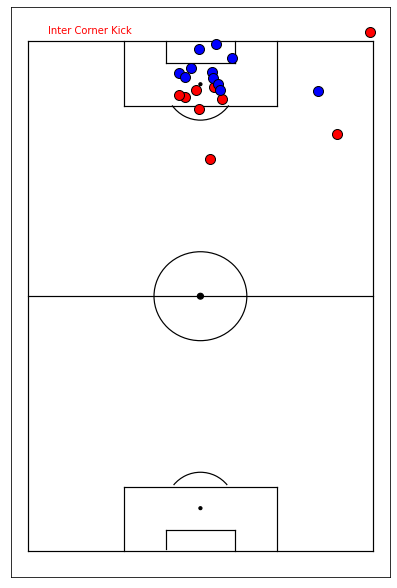

In [40]:
vis.basic_plotter_together(tracking=tracking_objs[0], frame = 5419, team_name="Inter")

In [41]:
list(defensing_team_locs.keys()) # team names

['Inter',
 'Juventus',
 'Paris',
 'Marseille',
 'Bayern Munchen',
 'Dortmund',
 'Liverpool',
 'Manchester City',
 'FC Barcelona',
 'Real Madrid']

In [42]:
team_name = "Inter"

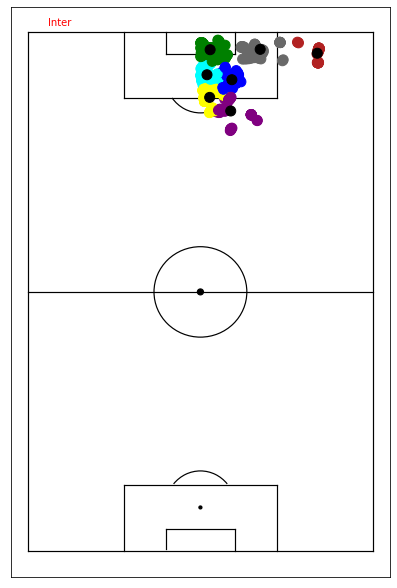

In [43]:
vis.k_means_plotter(defensing_team_locs[team_name], defensing_team_centroids_7[team_name], defensing_team_preds_colors_7[team_name], team_name, k = 7)